# Fitting foregrounds with missing modes

Would like to fit high lmax foregrounds using a model with a lower lmax = lmod.
This reduces the fidelity of our reconstruction. Let's use missing 
modes-modelling assuming that the missing modes are Gaussian with the same power
spectrum as the foregrounds and see if this helps.

In [12]:
from pygdsm import GlobalSkyModel2016
import healpy as hp
import numpy as np
from numpy.linalg import svd
from scipy.special import eval_legendre
import matplotlib.pyplot as plt
import seaborn as sns

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM

RS = SH.RealSphericalHarmonics()

In [3]:
lmax=32
nside=16
npix = hp.nside2npix(nside)
# Generate the ylm matrix for later.
ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)

# Generate foreground map.
fg_full_map = GlobalSkyModel2016(resolution='low').generate(60)

# Convert foreground map to real alm and Cl.
fg_cl = hp.sphtfunc.anafast(fg_full_map, lmax=64*2)
fg_gauss_alm = hp.map2alm(fg_full_map, lmax=lmax)
fg_gauss_alm = RS.complex2RealALM(fg_gauss_alm)

3072 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


In [18]:
# Observe the Gaussian random field.
narrow_cosbeam = lambda x : BF.beam_cos(x, theta0=0.8)
times = np.linspace(0, 24, 40, endpoint=False)
lats = np.linspace(-60, 60, 13)
#mat_A_fm, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan(nside=nside, lmax=lmax, lats=lats, beam_use=narrow_cosbeam, times=times, return_mat=True)
###################
mat_A_fm, (mat_G, mat_Y, mat_B) = FM.calc_observation_matrix_all_pix(nside=nside, lmax=lmax, Ntau=1500, Nt=npix, beam_use=narrow_cosbeam, return_mat=True)
mat_P_identity = np.diag([1]*npix)
mat_A_fm = mat_G @ mat_P_identity @ mat_Y @ mat_B
###################
d = mat_A_fm @ fg_gauss_alm

# Add noise.
#d_noisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=1e4, seed=124)
d_noisy, noise_covar = SM.add_noise(d, 1, Ntau=2000, t_int=1e4, seed=124)

3072 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


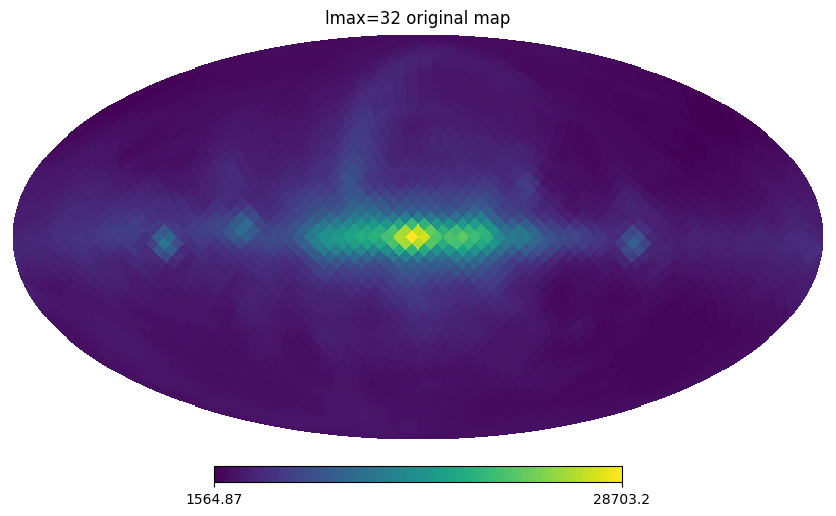

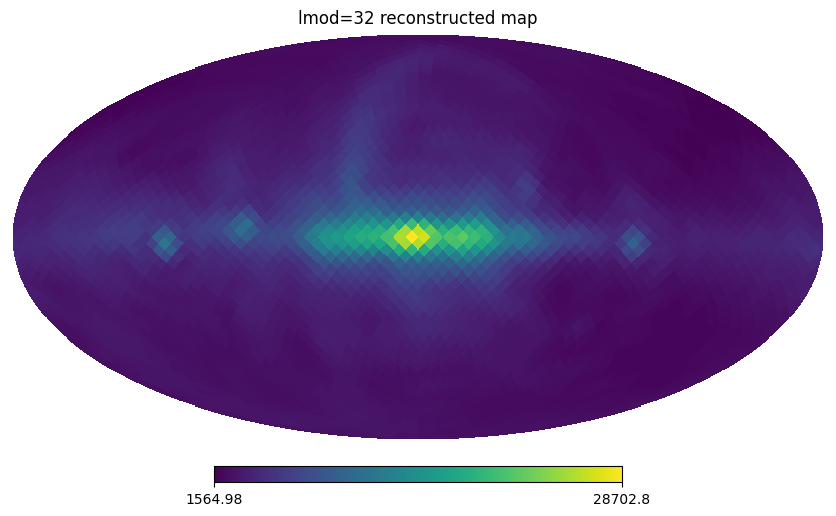

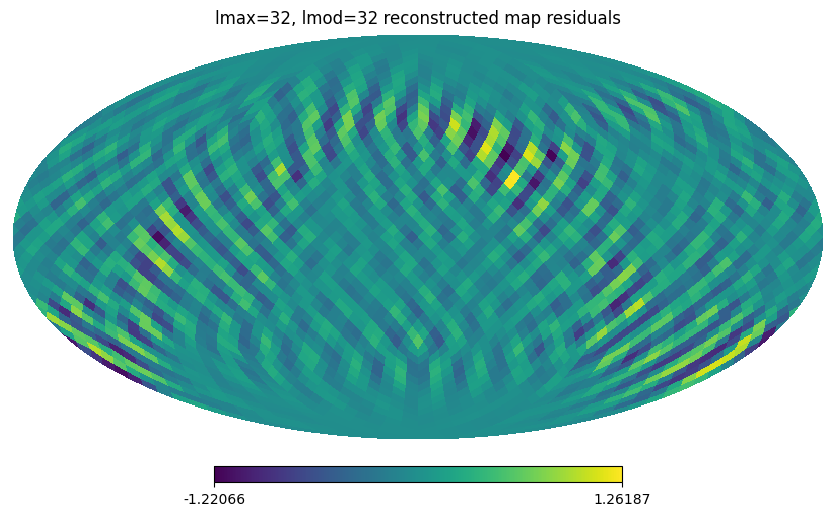

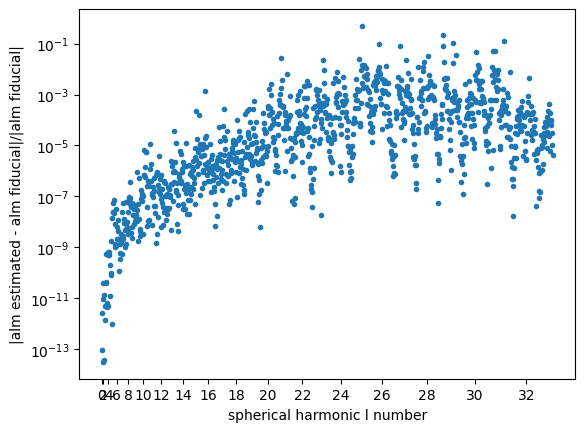

0.3138274262988814

In [19]:
mat_W_perfect, cov_perfect = MM.calc_ml_estimator_matrix(mat_A=mat_A_fm, mat_N=noise_covar, cov=True)
a_ml_noisefree = mat_W_perfect @ d
compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_noisefree, ylm_mat=ylm_mat)

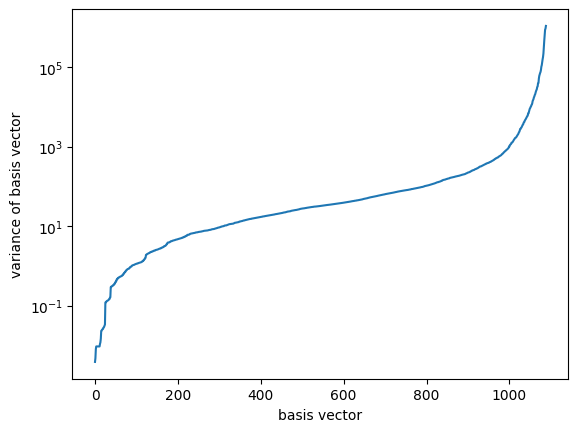

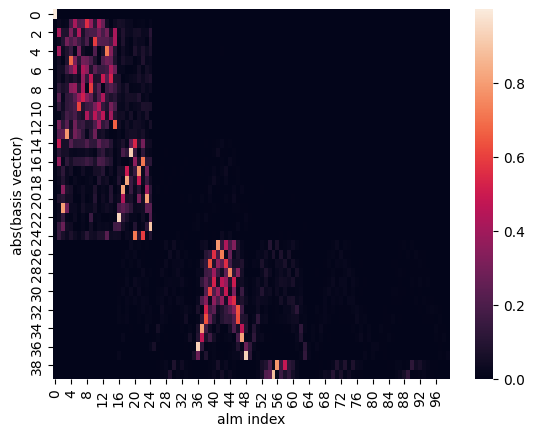

Text(0.5, 0, 'alm index')

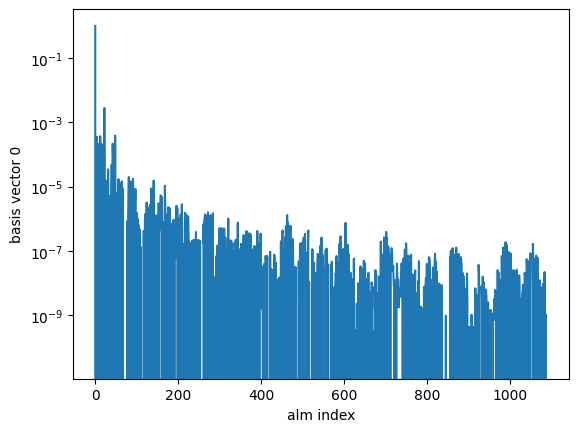

In [21]:
# Carry out SVD on the covariance matrix of the reconstructed alm. 
mat_U, arr_S, mat_Vh = svd(cov_perfect, full_matrices=False)

# Flip the arrays: we're interested in the lowest-variance components.
arr_S = np.flip(arr_S)
mat_Vh = np.flip(mat_Vh, axis=0)
mat_U = np.flip(mat_U, axis=1)

# Plot things of interest.
plt.semilogy(np.sqrt(arr_S))
plt.xlabel("basis vector")
plt.ylabel("variance of basis vector")
plt.show()

sns.heatmap(abs(mat_Vh[0:40,:100]))
plt.ylabel("abs(basis vector)")
plt.xlabel("alm index")
plt.show()

plt.semilogy(mat_Vh[0])
plt.ylabel("basis vector 0")
plt.xlabel("alm index")

In [ ]:
rms_trend = []
for Ntau in [500, 1000, 1500, 2000, 2500, 3000]:
    mat_A_fm, (mat_G, mat_Y, mat_B) = FM.calc_observation_matrix_all_pix(nside=nside, lmax=lmax, Ntau=Ntau, Nt=npix, beam_use=narrow_cosbeam, return_mat=True)
    d = mat_A_fm @ fg_gauss_alm
    d_noisy, noise_covar = SM.add_noise(d, 1, Ntau=Ntau, t_int=1e4, seed=124)

    # First model the Gaussian random field perfectly.
    mat_W_perfect = MM.calc_ml_estimator_matrix(mat_A=mat_A_fm, mat_N=noise_covar)
    a_ml_noisefree = mat_W_perfect @ d
    a_ml_noisy = mat_W_perfect @ d_noisy

    # Noise free case.
    rms_trend.append(compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_noisefree, ylm_mat=ylm_mat))


Text(0, 0.5, 'Total RMS reconstruction error')

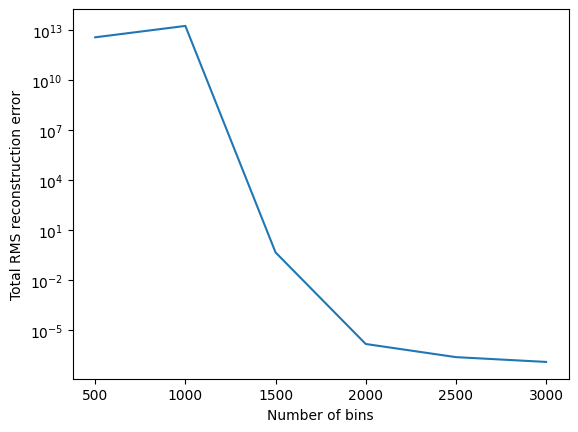

In [20]:
plt.semilogy([500, 1000, 1500, 2000, 2500, 3000], rms_trend)
plt.xlabel("Number of bins")
plt.ylabel("Total RMS reconstruction error")

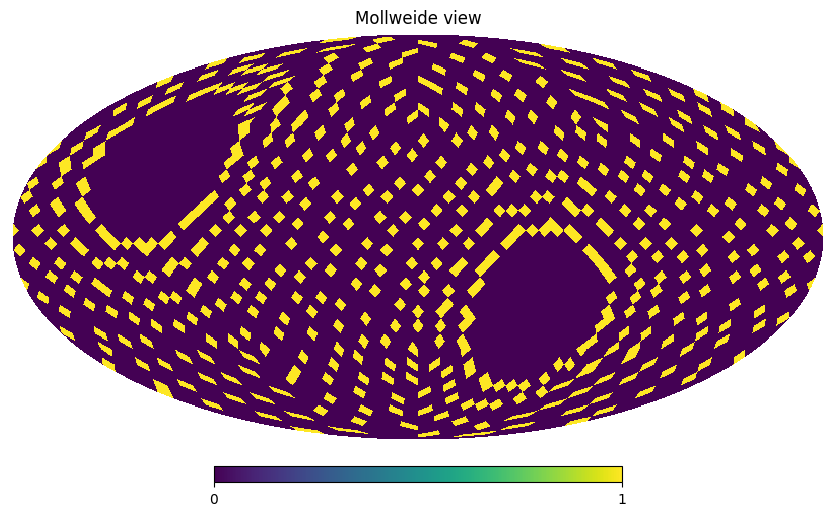

In [16]:
def find_ones_columns(matrix):
    # Convert the input matrix to a NumPy array
    np_matrix = np.array(matrix)
    # Use np.argmax to find the column index of the first occurrence of 1 in each row
    ones_columns = np.argmax(np_matrix, axis=1).tolist()
    return ones_columns
    
indxs = find_ones_columns(mat_P)
m = np.zeros(hp.nside2npix(nside))
for indx in indxs:
    m[indx] += 1
hp.mollview(map=m)

In [25]:
# Sort the P matrix to see if that would change anything.
ordering = np.argsort(np.array(indxs))
mat_P_ordered = mat_P[ordering]

# Observe with the ordered P-matrix.
mat_A_ordered = mat_P_ordered @ mat_Y @ mat_B
d_ordered = mat_A_ordered @ fg_gauss_alm

In [5]:
def compare_estimate_to_reality(a_reality, a_estimate, ylm_mat=None, nside=None):
    """
    Plot various figures comparing the resonstructed map to the original map,
    and the residuals of the estimated alm.

    Parameters
    ----------
    a_reality, a_estimate
        alm vectors corresponding to the fiducial map and the estimated map
        respectively. a_reality should be as long or longer than a_estimate.
    ylm_mat
        Ylm matrix corresponding to a_reality. This is chopped down to use for 
        a_estimate too. If none is passed, one will be created.
    nside
        If a Ylm matrix is being created, must pass a value for its nside. If 
        a Ylm matrix is being passed, the nside argument is ignored.    
    """
    try:
        lmax = RS.get_lmax(len(a_reality))
        lmod = RS.get_lmax(len(a_estimate))
        if lmod > lmax:
            msg = 'fiducial alm vector must be as long or longer than the ' \
                + 'estimated alm vector.'
            raise ValueError(msg)
    except ValueError:
        raise ValueError('invalid alm vector length.')
    
    if ylm_mat is None:
        if nside is None:
            raise ValueError("if Ylm matrix isn't passed, nside should be.")
        ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)
    
    no_modes = len(a_estimate)
    ylm_mat_mod = ylm_mat[:, :no_modes]

    hp.mollview(ylm_mat@a_reality, title=f"lmax={lmax} original map")
    plt.show()

    hp.mollview(ylm_mat_mod@a_estimate, title=f"lmod={lmod} reconstructed map")
    plt.show()

    hp.mollview(ylm_mat_mod@a_estimate - ylm_mat@a_reality, 
                title=f"lmax={lmax}, lmod={lmod} reconstructed map residuals")
    plt.show()

    mode_residuals = abs(a_estimate[:no_modes] - a_reality[:no_modes])
    mode_residuals /= abs(a_reality[:no_modes])
    lmod_arr = list(range(0, lmod+1, 2))
    lmod_idx = [RS.get_idx(l=l, m=-l) for l in lmod_arr]
    plt.semilogy(range(no_modes), mode_residuals, '.')
    plt.xticks(ticks=lmod_idx, labels=lmod_arr)
    plt.xlabel("spherical harmonic l number")
    plt.ylabel("|alm estimated - alm fiducial|/|alm fiducial|")
    plt.show()
    return np.std(ylm_mat_mod@a_estimate - ylm_mat@a_reality)
    

def compare_reconstructions(a_reality, *a_estimates, labels=None, fmts=None, ylm_mat=None):
    """
    Compare the errors in reconstructions of the original alm vector by plotting
    the residuals of the vectors and optionally a bar chart of the different temperature
    standard deviations from the fiducial map.

    Parameters
    ----------
    a_reality, a_estimates
        Fiducial alm vector and set of estimated alm vectors. Estimated vectors
        must be as long or shorter than the fiducial vector.
    labels
        List of labels for the different estimates.
    fmts
        List of scatter plot format arguments for the estimates.
    ylm_mat
        ylm matrix corresponding to a_reality. If passed, calculates the
        residuals of the reconstructed temperature maps for each of the
        estimates and produces a bar plot.
    """
    no_modes = min([len(a) for a in a_estimates])
    lmod = RS.get_lmax(no_modes)
    lmod_arr = list(range(0, lmod+1, 2))
    lmod_idx = [RS.get_idx(l=l, m=-l) for l in lmod_arr]

    if labels is None:
        labels = ['']*len(a_estimates)
    if fmts is None:
        fmts = ['.']*len(a_estimates)
    
    for a_estimate, label, fmt in zip(a_estimates, labels, fmts):
        mode_residuals = abs(a_estimate[:no_modes] - a_reality[:no_modes])
        mode_residuals /= abs(a_reality[:no_modes])
        plt.semilogy(range(no_modes), mode_residuals, fmt, label=label)
    plt.legend()
    plt.xticks(ticks=lmod_idx, labels=lmod_arr)
    plt.xlabel("spherical harmonic l number")
    plt.ylabel("|alm estimated - alm fiducial|/|alm fiducial|")
    plt.show()

    # Make a bar chart comparing the reconstruction error in rms temperature.
    if ylm_mat is not None:
        map_reality = ylm_mat @ a_reality
        ylm_mats_trunc = [ylm_mat[:,:len(a)] for a in a_estimates]
        map_estimates = [y_mat @ a for y_mat, a in zip(ylm_mats_trunc, a_estimates)]
        rms = [np.std(map_reality - map_est) for map_est in map_estimates]
        plt.bar(x=list(range(len(rms))), height=rms)
        plt.xticks(ticks=list(range(len(rms))), labels=labels)
        plt.ylabel("RMS temperature error [K]")
        plt.xticks(rotation=30)
        plt.show()
    
    if ylm_mat is not None:
        lmax = RS.get_lmax(len(a_reality))
        idxs = [RS.get_idx(l=l, m=l)+1 for l in range(lmax)]
        cutoff_realities = np.array([ylm_mat[:,:i] @ a_reality[:i] for i in idxs])
        for a, label, fmt in zip(a_estimates, labels, fmts):
            lmax_a = RS.get_lmax(len(a))
            idxs = [RS.get_idx(l=l, m=l)+1 for l in range(lmax_a)]
            cutoff_estimates = np.array([ylm_mat[:,:i] @ a[:i] for i in idxs])
            rms = np.std(cutoff_estimates-cutoff_realities[:len(idxs)], axis=1)
            plt.semilogy(list(range(lmax_a)), rms, fmt, label=label)
        plt.xlabel("spherical harmonic l number")
        plt.ylabel("RMS temperature residuals [K]")
        plt.legend()
        plt.show()

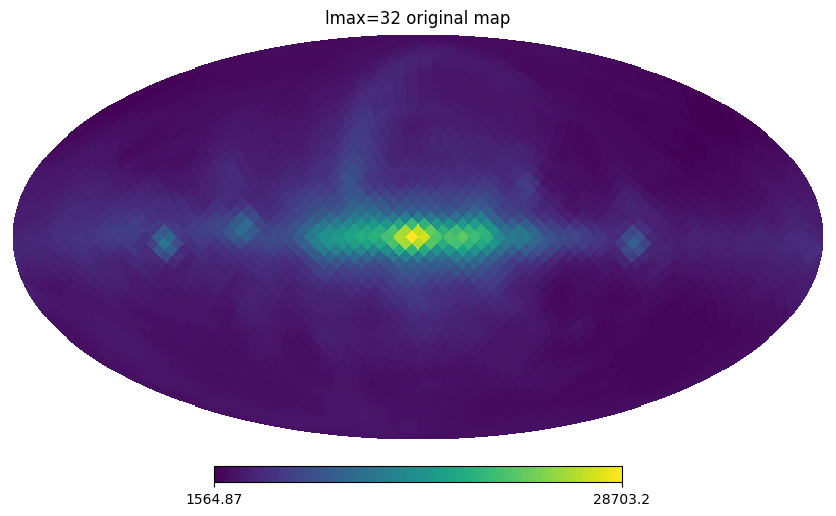

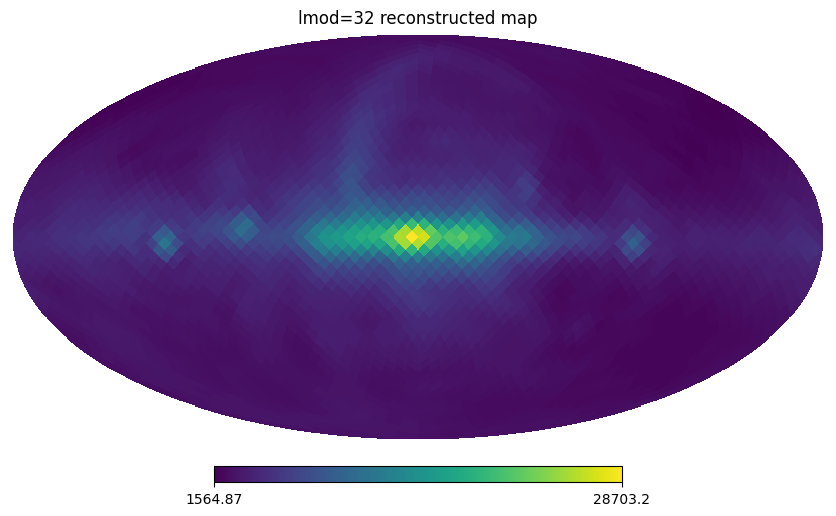

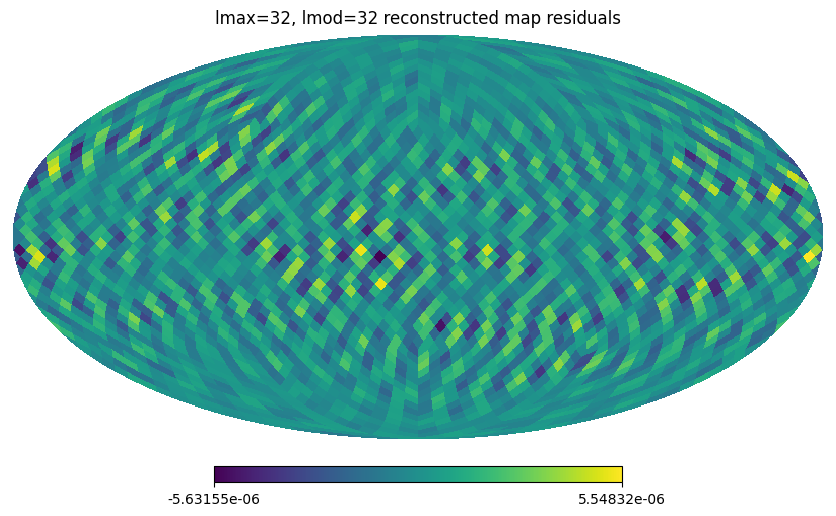

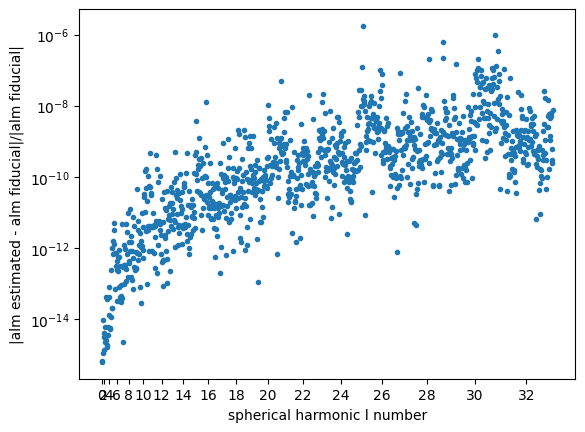

1.5179905176329118e-06

In [6]:
# First model the Gaussian random field perfectly.
mat_W_perfect = MM.calc_ml_estimator_matrix(mat_A=mat_A_fm, mat_N=noise_covar)
a_ml_noisefree = mat_W_perfect @ d
a_ml_noisy = mat_W_perfect @ d_noisy

# Noise free case.
compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_noisefree, ylm_mat=ylm_mat)

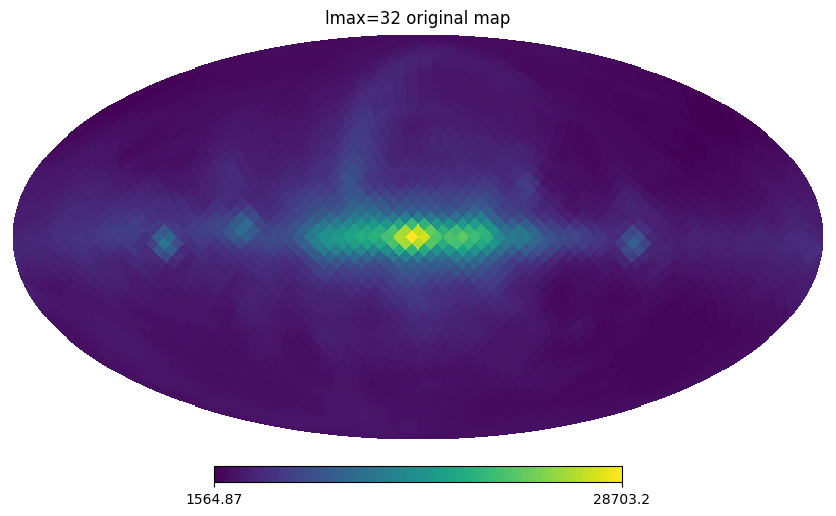

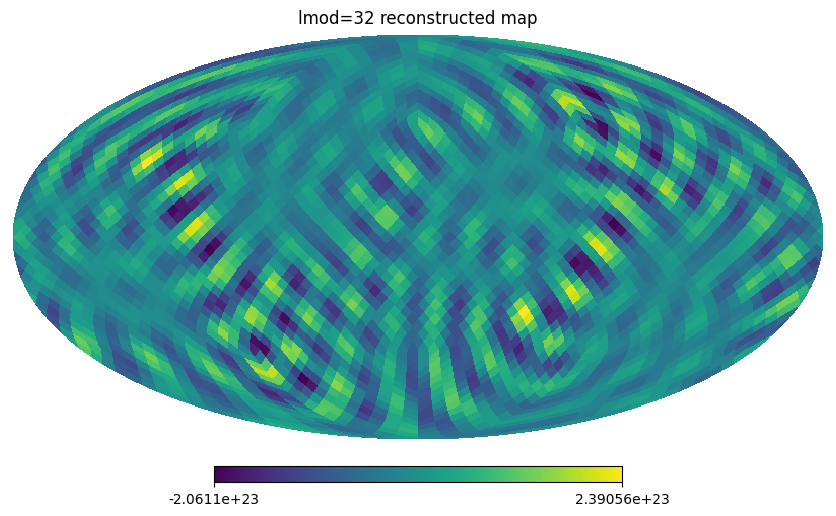

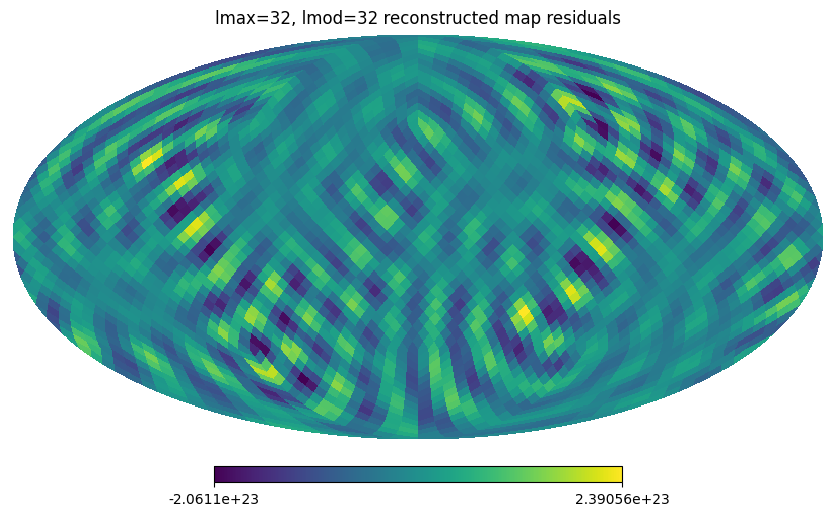

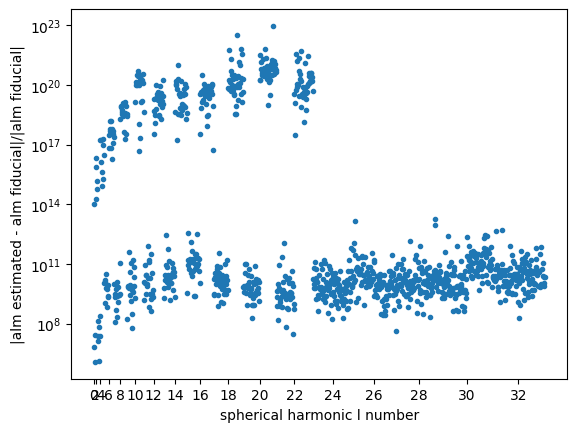

In [8]:
# Noisy case.
compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_noisy, ylm_mat=ylm_mat)

In [12]:
from importlib import reload
reload(FM)

<module 'src.forward_model' from '/Users/yordani/Documents/boosted_compass/matrix-observer/src/forward_model.py'>

3072 276


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


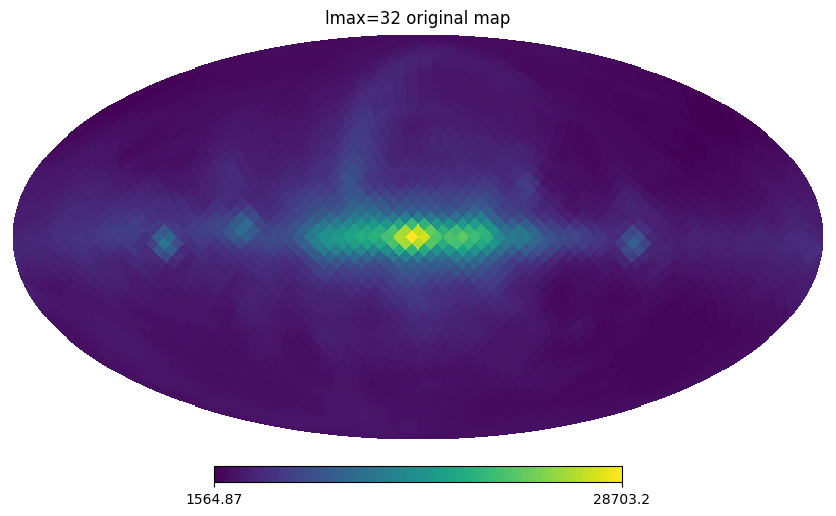

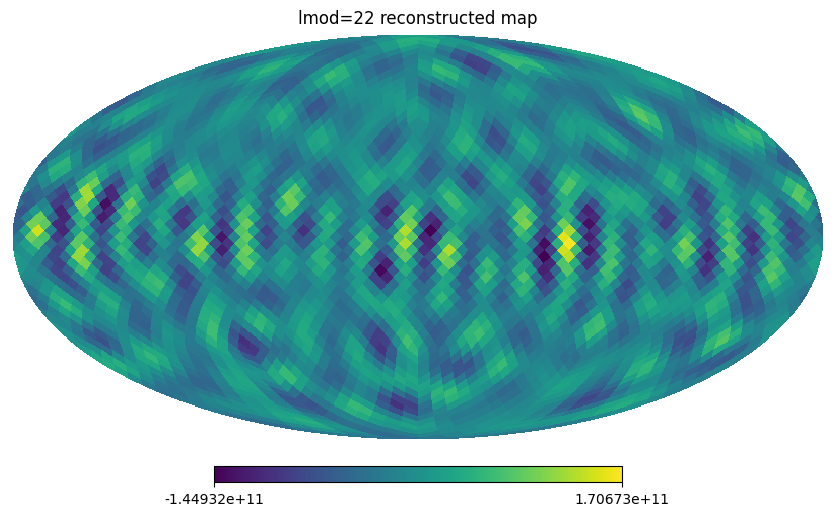

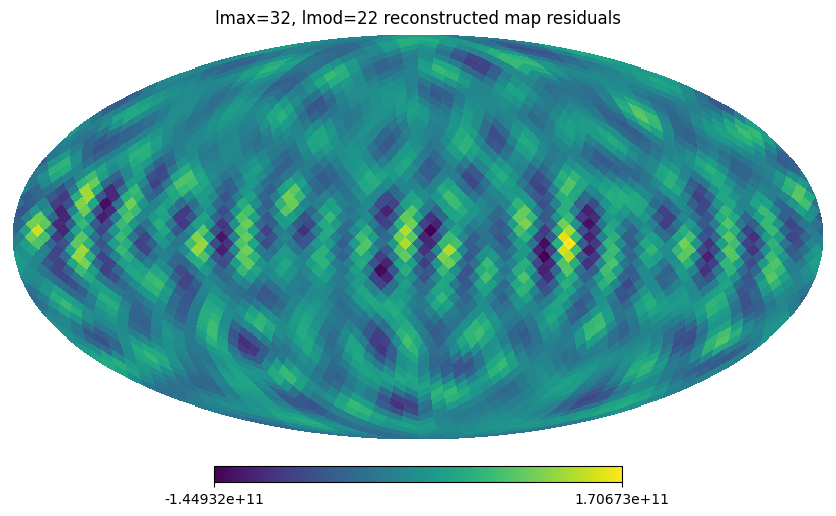

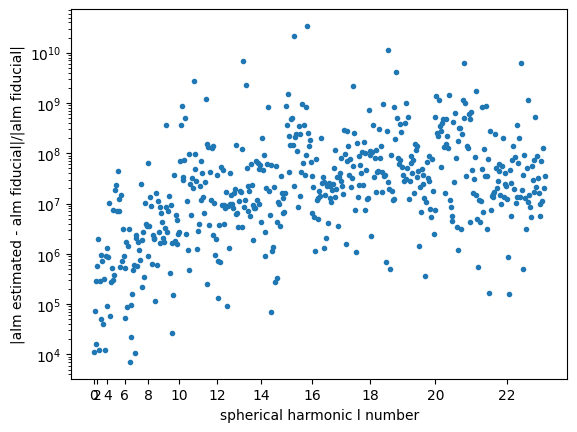

In [15]:
# Now model the field badly with missing modes.
lmod = 22
mat_A_lowl, mats = FM.calc_observation_matrix_multi_zenith_driftscan(nside=nside, lmax=lmod, lats=lats, beam_use=narrow_cosbeam, times=times, return_mat=True)
mat_W_lowl = MM.calc_ml_estimator_matrix(mat_A=mat_A_lowl, mat_N=noise_covar)
mat_G_lowl, mat_P_lowl, mat_Y_lowl, mat_B_lowl = mats
a_ml_lowl_noisefree = mat_W_lowl @ d
a_ml_lowl_noisy = mat_W_lowl @ d_noisy

# Noise free case
compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_lowl_noisefree, ylm_mat=ylm_mat)

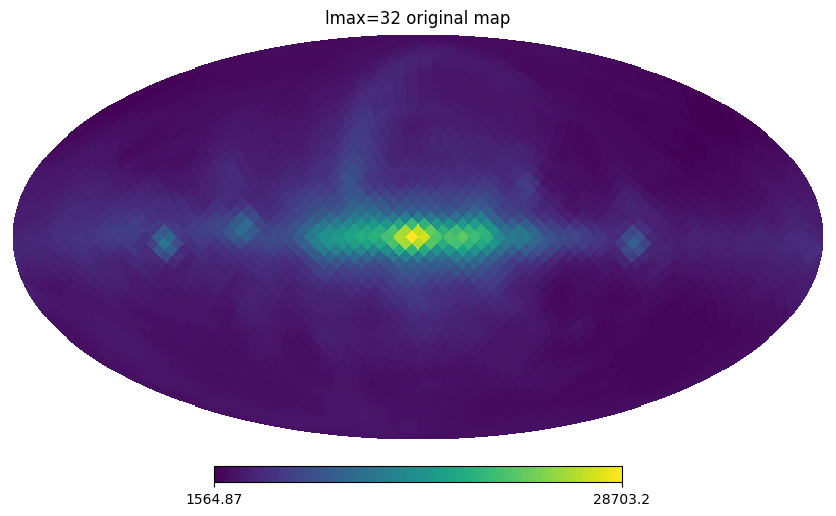

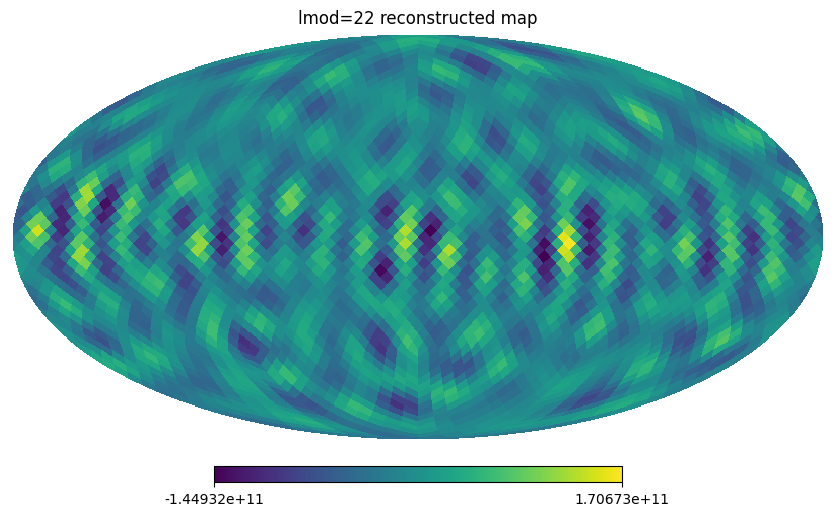

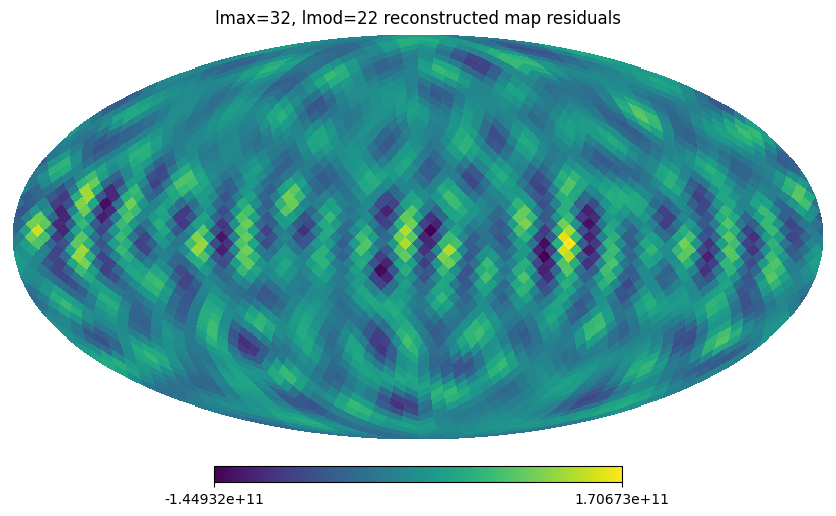

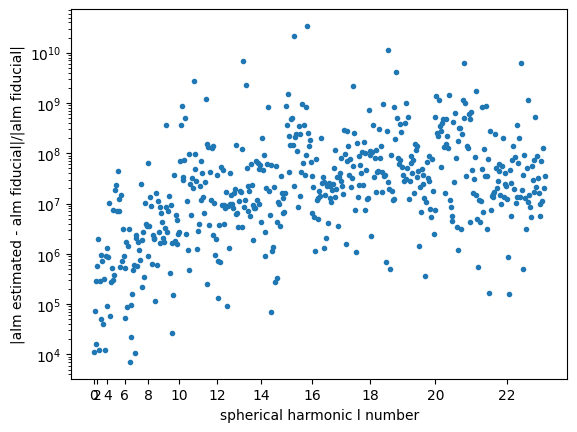

In [16]:
# Noisy case.
compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_lowl_noisy, ylm_mat=ylm_mat)

In [17]:
# Now incorporate some missing-modes modelling.
def calc_full_unmodelled_mode_matrix(lmod, lmax, nside, foreground_power_spec, beam_mat, binning_mat, pointing_mat):
    """
    Calculate the unmodelled mode matrix for the non-trivial observation 
    strategy and binning of timeseries data into Ntau bins.
    """
    npix = hp.nside2npix(nside)
    vectors = hp.pix2vec(nside, ipix=list(range(npix)))
    vectors = np.array(vectors).T
    vector_difference = np.einsum("pi,qi->pq", vectors, vectors)
    binpoint_mat = binning_mat@pointing_mat
    val = np.sum([((2*l+1)/(4*np.pi)) * eval_legendre(l, vector_difference) * foreground_power_spec[l] * beam_mat[l,l]**2 for l in range(lmod+1, lmax)], axis=0)
    return binpoint_mat@val@(binpoint_mat.T)

mat_S = calc_full_unmodelled_mode_matrix(lmod=lmod, lmax=lmax, foreground_power_spec=fg_cl, nside=nside, beam_mat=mat_B_lowl, binning_mat=mat_G_lowl, pointing_mat=mat_P_lowl)

# Carry out the corrected ML estimate.
mat_W_corrected = MM.calc_ml_estimator_matrix(mat_A=mat_A_lowl, mat_N=noise_covar+mat_S)
a_ml_corrected_noisefree = mat_W_corrected @ d
a_ml_corrected_noisy = mat_W_corrected @ d_noisy

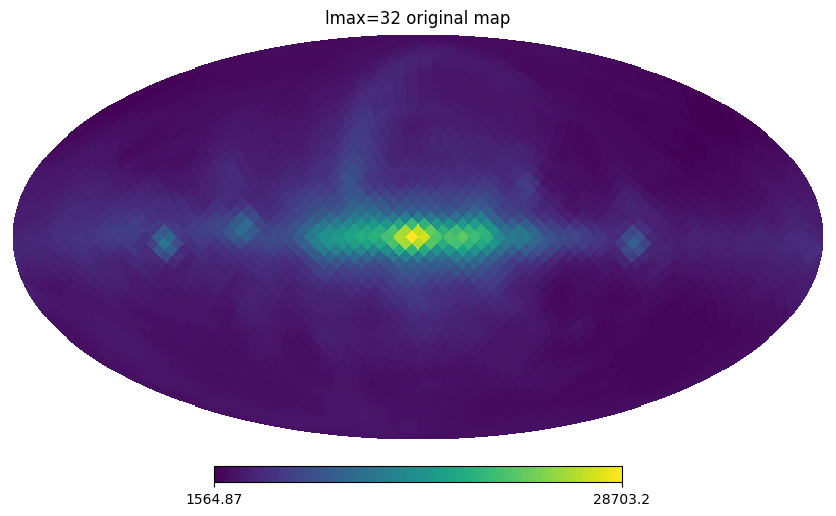

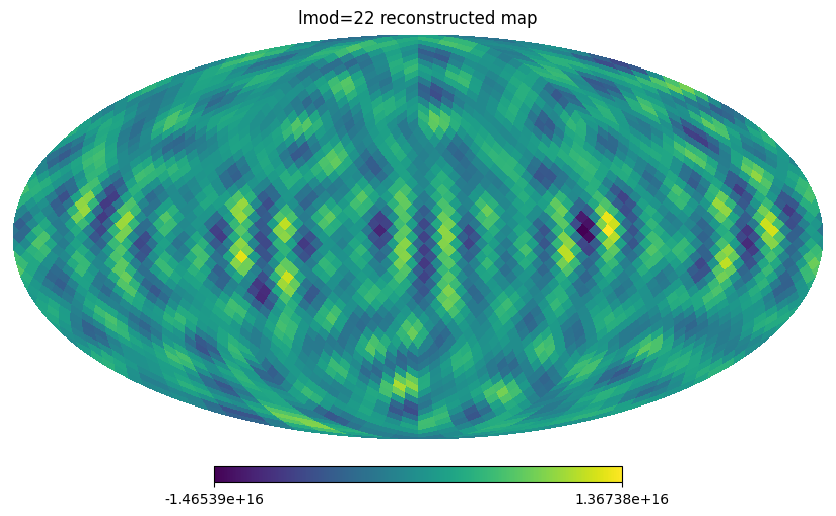

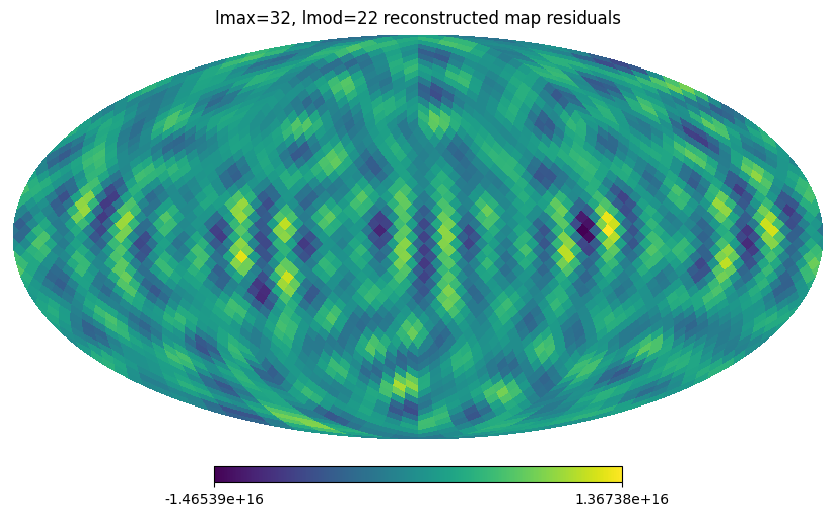

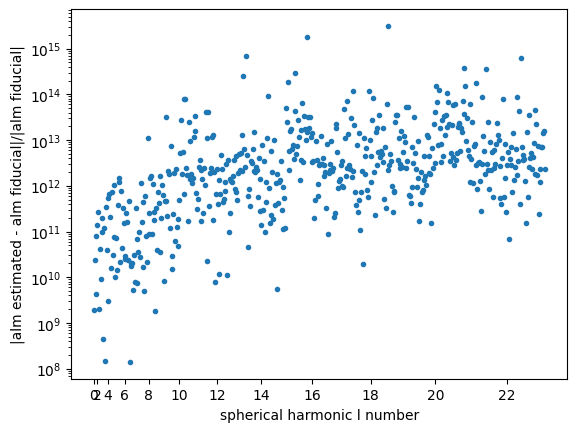

In [18]:
# Noise free case.
compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_corrected_noisefree, ylm_mat=ylm_mat)

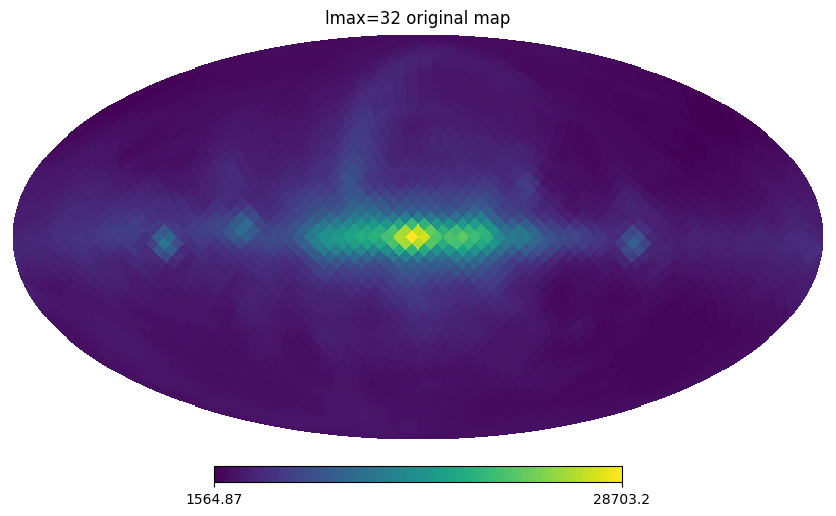

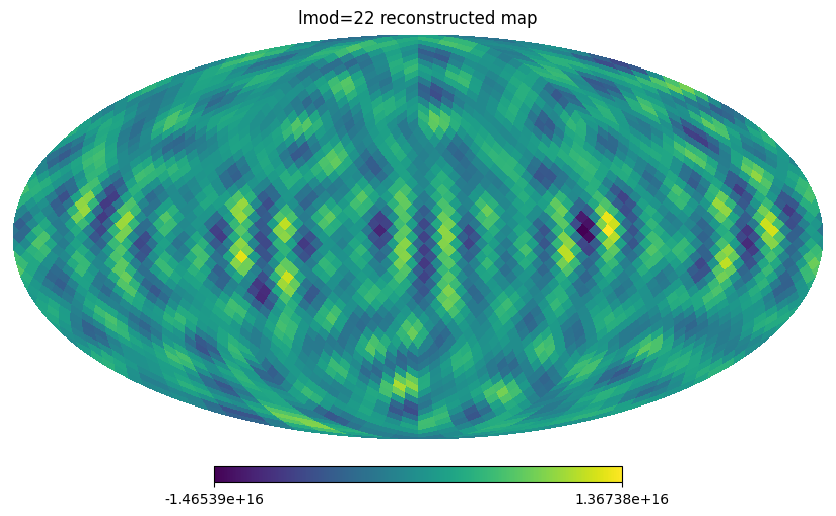

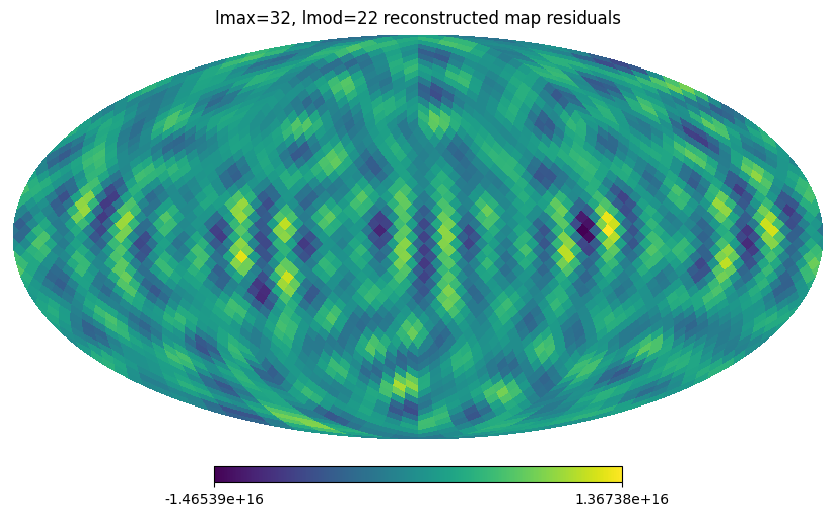

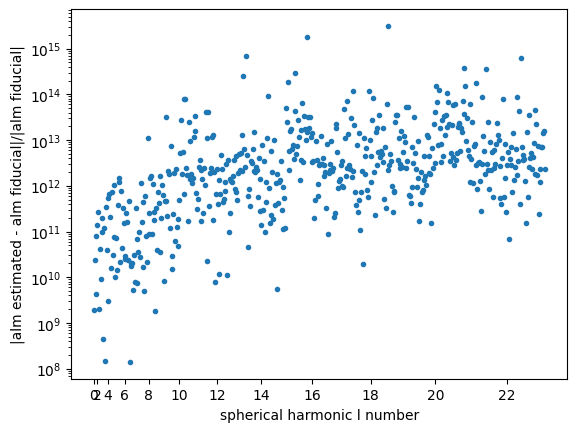

In [19]:
# Noisy case.
compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_corrected_noisy, ylm_mat=ylm_mat)

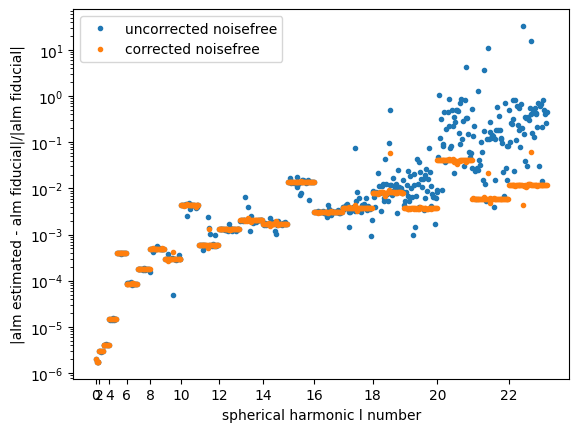

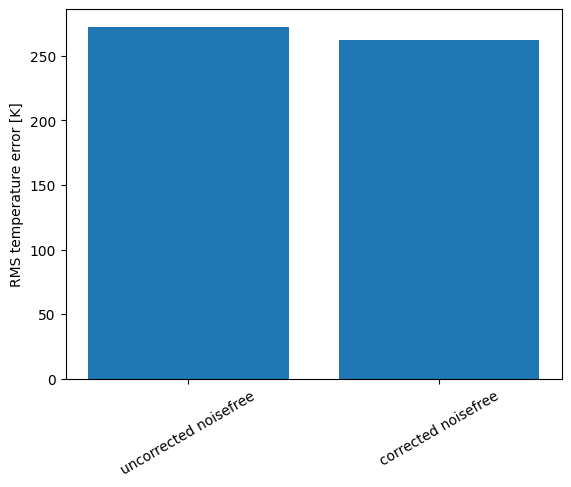

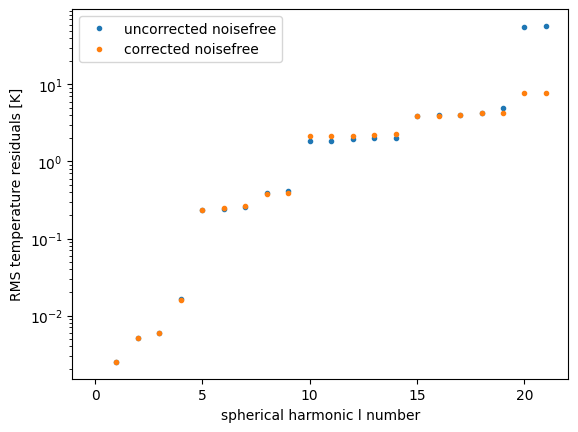

In [ ]:
compare_reconstructions(fg_gauss_alm, a_ml_lowl_noisefree, a_ml_corrected_noisefree, labels=['uncorrected noisefree', 'corrected noisefree'], ylm_mat=ylm_mat)

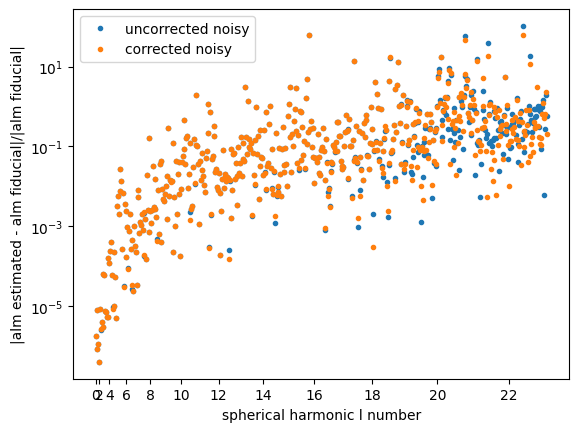

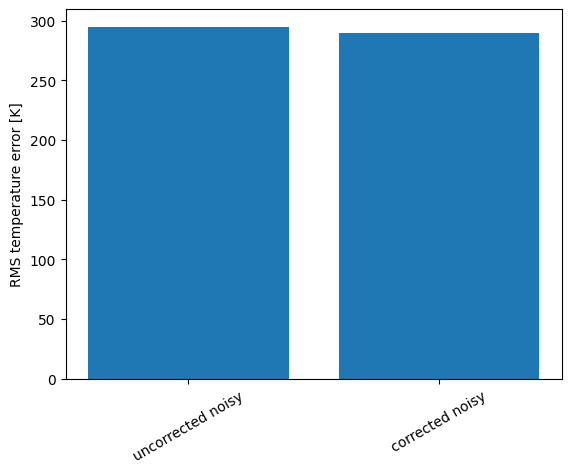

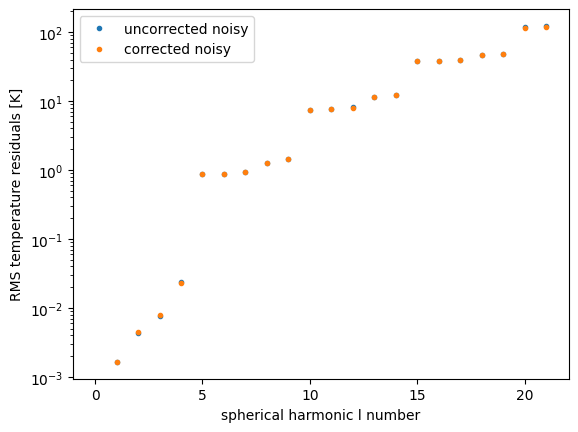

In [ ]:
compare_reconstructions(fg_gauss_alm, a_ml_lowl_noisy, a_ml_corrected_noisy, labels=['uncorrected noisy', 'corrected noisy'], ylm_mat=ylm_mat)

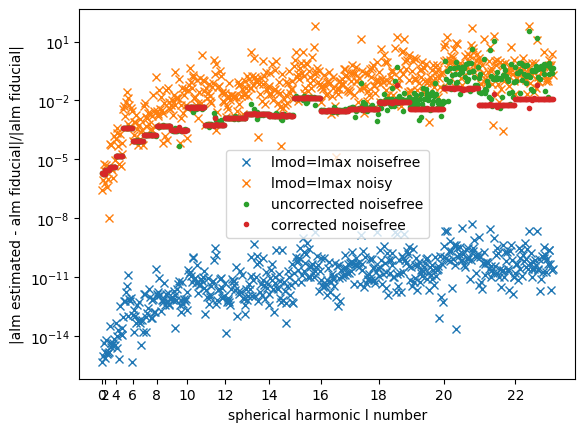

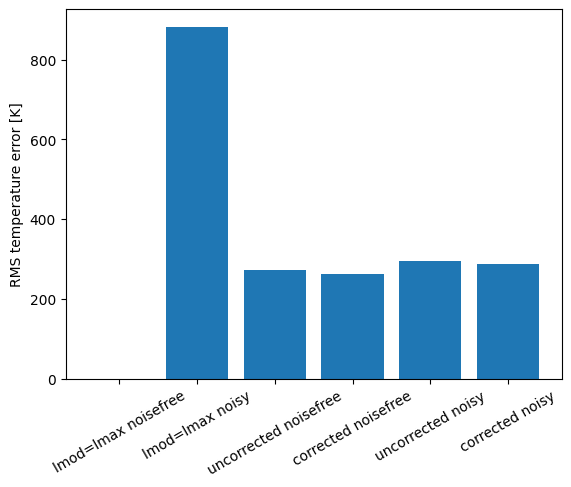

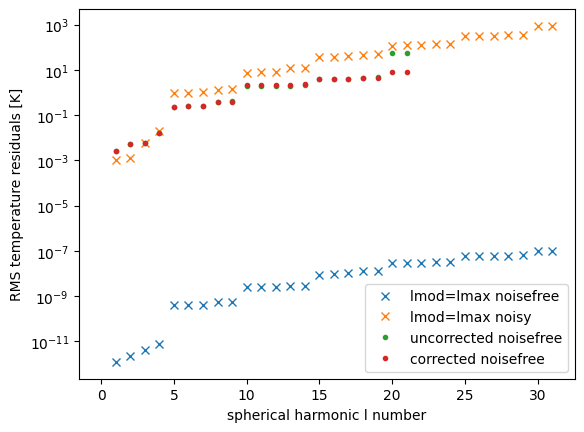

In [ ]:
compare_reconstructions(fg_gauss_alm, a_ml_noisefree, a_ml_noisy, a_ml_lowl_noisefree, a_ml_corrected_noisefree, a_ml_lowl_noisy, a_ml_corrected_noisy, labels=['lmod=lmax noisefree', 'lmod=lmax noisy', 'uncorrected noisefree', 'corrected noisefree', 'uncorrected noisy', 'corrected noisy'], fmts=['x', 'x', '.', '.'], ylm_mat=ylm_mat)

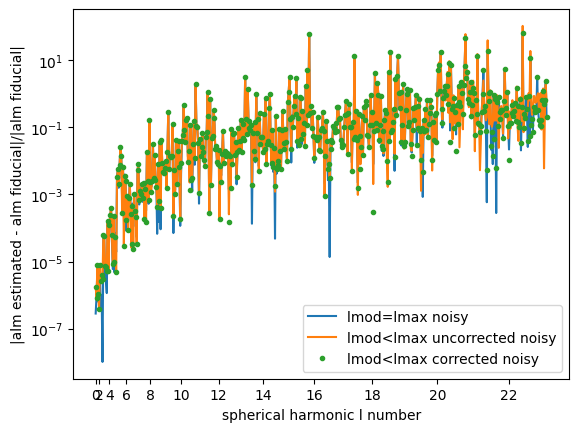

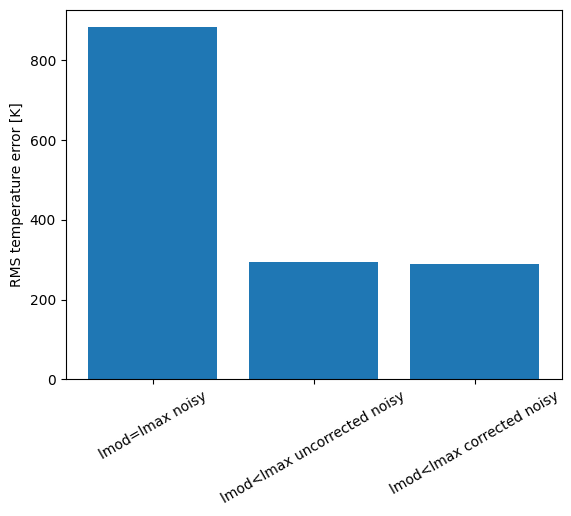

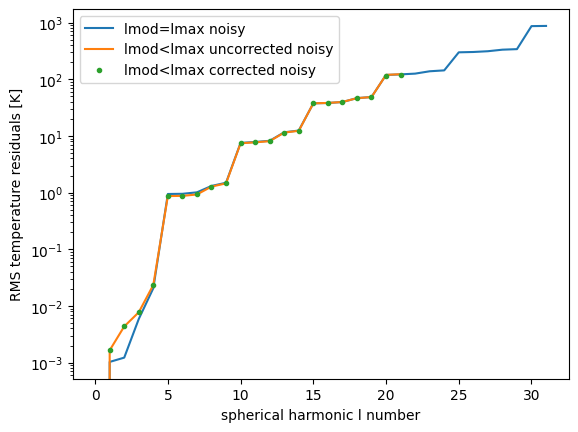

In [ ]:
compare_reconstructions(fg_gauss_alm, a_ml_noisy, a_ml_lowl_noisy, a_ml_corrected_noisy, labels=['lmod=lmax noisy', 'lmod<lmax uncorrected noisy', 'lmod<lmax corrected noisy'], fmts=['-', '-', '.'], ylm_mat=ylm_mat)

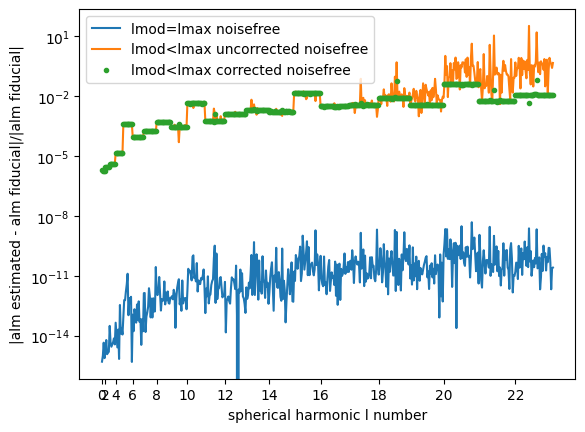

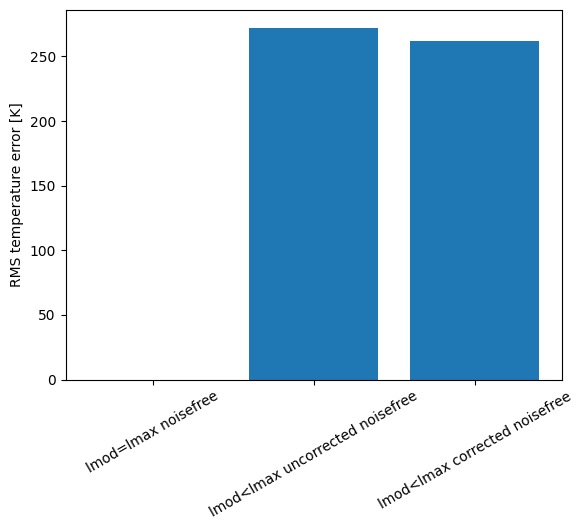

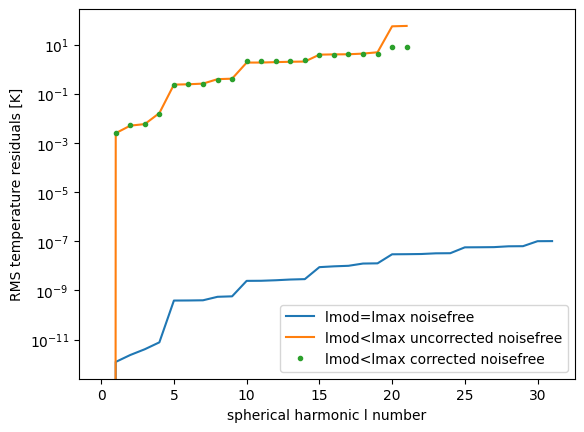

In [ ]:
compare_reconstructions(fg_gauss_alm, a_ml_noisefree, a_ml_lowl_noisefree, a_ml_corrected_noisefree, labels=['lmod=lmax noisefree', 'lmod<lmax uncorrected noisefree', 'lmod<lmax corrected noisefree'], fmts=['-', '-', '.'], ylm_mat=ylm_mat)